# Historical coverage for data sources in OpenSAFELY

This [OpenSAFELY](https://www.opensafely.org/) notebook provides information about historical coverage of externally linked data sources in the [OpenSAFELY-TPP database](https://docs.opensafely.org/dataset-systmone/). It is part of the technical documentation for users of the OpenSAFELY platform to guide analyses and **it should not be used for inference about any aspect of the pandemic, public health, or health service activity**. For the avoidance of doubt: any clinical or epidemiological interpretation of this raw information is likely to be a misinterpretation. 

If you would like to apply to use the OpenSAFELY platform please read our [documentation](https://docs.opensafely.org/), the [principles of the platform](https://www.opensafely.org/about/), and information about our [pilot programme for onboarding external users](https://www.opensafely.org/onboarding-new-users/).

If you want to see the Python code used to create this notebook, you can [view it on GitHub](https://github.com/opensafely/database-notebooks/blob/master/notebooks/database-builds.ipynb).

## Data sources
Data sources are listed below, with the table name in the database given in brackets:

* All positive or negative SARS-CoV2 tests, from SGSS (`SGSS_AllTests_Positive` and `SGSS_AllTests_Negative`)
* First-ever positive or negative SARS-CoV2 test, from SGSS (`SGSS_Positive` and `SGSS_Negative`)
* A&E attendances, from SUS Emergency Care data (`EC`)
* In-patient hospital admissions, from SUS Admitted Patient Care Spells data (`APCS`)
* Out-patient hospital appointments, from SUS (`OPA`)
* Covid-related ICU admissions, from ICNARC (`ICNARC`)
* Covid-related in-hospital deaths, from CPNS (`CPNS`)
* COVID-19 Infection Survey, from ONS (`ONS_CIS`)
* All-cause registered deaths, from ONS (`ONS_Deaths`)
* High cost drugs (`HighCostDrugs`)
* Unique Property Reference Number, used for deriving household variables (`UPRN`)
* Master Patient Index (`MPI`)
* Health and Social Care Worker identification, collected at the point of vaccination (`HealthCareWorker`)


In [1]:
## Import libraries

%load_ext autoreload
%autoreload 2

import pyodbc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.dates as mdates
from contextlib import contextmanager
from datetime import date, datetime
from IPython.display import display, Markdown

import sys
sys.path.append('../lib/')
from functions import *

In [2]:
# get server credentials from environment variable

dbconn = os.environ.get('FULL_DATABASE_URL', None).strip('"')

In [3]:
## Import libraries

with closing_connection(dbconn) as cnxn:
    DBbuild = pd.read_sql("""select * from LatestBuildTime""", cnxn)
    latestbuilds = pd.read_sql(
    """
        select BuildDesc as dataset, max(BuildDate) as latest_import from BuildInfo
        group by BuildDesc
    """, cnxn)
    allbuilds = pd.read_sql("""select * from BuildInfo""", cnxn)

# select start and end dates
start_date = pd.to_datetime("2016-01-01", format='%Y-%m-%d')
#start_date = pd.to_datetime("2020-02-01", format='%Y-%m-%d')
end_date = pd.to_datetime(latestbuilds['latest_import'].max(), format='%Y-%m-%d')
run_date = date.today()

## Notebook run date

In [4]:
display(Markdown(f"""This notebook was run on {run_date.strftime('%-d %B %Y')}.  The information below reflects the state of the OpenSAFELY-TPP database as at this date."""))

This notebook was run on 7 February 2022.  The information below reflects the state of the OpenSAFELY-TPP database as at this date.

## Event activity in external datasets

In the figures below, event activity (counts of patient events such as hospital admissions and deaths) is reported for external data sources from no earlier than 1 January 2016 up to the notebook run date.

Note that the OpenSAFELY-TPP database only includes people who were ever registered at a GP practice using TPP's SystmOne clinical information system (roughly 40% of GP practices) on or after 1 January 2009, including those who have since deregistered or died. The data therefore captures activity for these patients only.

Counts of five or less are redacted. 

In [5]:
def datequery(table, var, from_date):
    query = (
      f"""
        SELECT {var} AS date, COUNT(*) AS count
        FROM {table}
        WHERE {var} >= CONVERT(date, '{from_date}')
        GROUP BY {var}
        ORDER BY {var}
      """
    )
    return query

start_date_text = start_date.strftime('%Y-%m-%d')
#CodedEvent_query = datequery("CodedEvent", "ConsultationDate", start_date_text)
#Appointment_query = datequery("Appointment", "SeenDate", start_date_text)
APCS_query = datequery("APCS", "Admission_Date", start_date_text)
CPNS_query = datequery("CPNS", "DateOfDeath", start_date_text)
EC_query = datequery("EC", "Arrival_Date", start_date_text)
OPA_query = datequery("OPA", "Appointment_Date", start_date_text)
ICNARC_query = datequery("ICNARC", "CONVERT(date, IcuAdmissionDateTime)", start_date_text)
ONS_query = datequery("ONS_Deaths", "dod", start_date_text)
SGSS_query = datequery("""( 
         SELECT Earliest_Specimen_Date FROM SGSS_Positive 
         UNION ALL
         SELECT Earliest_Specimen_Date FROM SGSS_Negative
         ) AS a """, 
        "Earliest_Specimen_Date", start_date_text)
SGSSpos_query = datequery("SGSS_Positive", "Earliest_Specimen_Date", start_date_text)
SGSS_AllTests_query = datequery("""( 
         SELECT Specimen_Date FROM SGSS_AllTests_Positive 
         UNION ALL
         SELECT Specimen_Date FROM SGSS_AllTests_Negative
         ) AS a """, 
        "Specimen_Date", start_date_text)
SGSSpos_AllTests_query = datequery("SGSS_AllTests_Positive", "Specimen_Date", start_date_text)

with closing_connection(dbconn) as cnxn:
    #CodedEvent_df = pd.read_sql(CodedEvent_query, cnxn, parse_dates=['coded_event_date'])
    #Appointment_df = pd.read_sql(Appointment_query, cnxn, parse_dates=['appointment_date'])
    APCS_df = pd.read_sql(APCS_query, cnxn, parse_dates=['date'])
    CPNS_df = pd.read_sql(CPNS_query, cnxn, parse_dates=['date'])
    EC_df = pd.read_sql(EC_query, cnxn, parse_dates=['date'])
    OPA_df = pd.read_sql(OPA_query, cnxn, parse_dates=['date'])
    ICNARC_df = pd.read_sql(ICNARC_query, cnxn, parse_dates=['date'])
    ONS_df = pd.read_sql(ONS_query, cnxn, parse_dates=['date'])
    SGSS_df = pd.read_sql(SGSS_query, cnxn, parse_dates=['date'])
    SGSSpos_df = pd.read_sql(SGSSpos_query, cnxn, parse_dates=['date'])
    SGSS_all_df = pd.read_sql(SGSS_AllTests_query, cnxn, parse_dates=['date'])
    SGSSpos_all_df = pd.read_sql(SGSSpos_AllTests_query, cnxn, parse_dates=['date'])
    
# Note that CodedEvent and Appointment extracts take a long time to run.
# The sql for the combined SGSS tables has stopped working, so are not currently run

In [6]:
def plotcounts_history(df, title=""):
    # This function plots event counts over time both overall and for the last X days up to the most recent extracted event.  
    
    
    
    startdate = df['date'].min()
    enddate = df['date'].max()
    
    date_range = pd.DataFrame(
        index = pd.date_range(start=startdate, end=enddate, freq="D")
    )
    
    startdatestring = startdate.strftime('%Y-%m-%d')
    enddatestring = enddate.strftime('%Y-%m-%d')
    
    def eventcountseries(df, date_range, rule='D', popadjust=False):
        # to calculate the daily count for events recorded in a series
        # where event_dates is a series
        # set popadjust = 1000, say, to report counts per 1000 population

        df = df.set_index('date')
        counts = df['count'].reindex(date_range.index, fill_value=0)

        if rule != "D":
            counts = counts.resample(rule).sum()

        if popadjust is not False:
            pop = counts.sum()
            poppern= pop/popadjust
            counts = counts.transform(lambda x: x/poppern)

        return(counts)

    counts_day = eventcountseries(df, date_range, rule="D")
    redact_day = (counts_day <6) & (counts_day>0)
    counts_day = counts_day.where(~redact_day, 3) #redact small numbers
    
    counts_week = eventcountseries(df, date_range, rule="W")
    redact_week = (counts_week <6) & (counts_week>0)
    counts_week = counts_week.where(~redact_week, 3) #redact small numbers
       
    fig, axs = plt.subplots(1, 1, figsize=(15,5))
    
    axs.plot(counts_day.index, counts_day, color='darkblue', zorder=2)
    axs.plot(counts_week.index - pd.DateOffset(3), counts_week/7, color='lightblue', zorder=3)
    axs.set_ylabel('event counts')
    axs.xaxis.set_tick_params(labelrotation=70)
    axs.set_ylim(bottom=0)
    axs.grid(True)
    axs.spines["left"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.set_title(f"""\n\n From {startdatestring} to {enddatestring}""")
    xlimlower, xlimupper = axs.get_xlim()
    ylimlower, ylimupper = axs.get_ylim()
    axs.add_patch(patches.Rectangle((xlimlower,0.5) ,xlimupper-xlimlower, 5, linewidth=1, edgecolor='none', facecolor='seashell', zorder=4))
       
    plt.subplots_adjust(top=0.8, wspace = 0.2, hspace = 0.9)
    plt.tight_layout()
    fig.suptitle("\n"+title, y=1, fontsize='x-large')
    plt.figtext(
        0, -0.07, 
        """
        Counts are based on raw event data and should not be used for clinical or epidemiological inference.
        Counts of five or less are set to 3 and masked for disclosure control.
        """,
        ha='left'
    )
    plt.show()

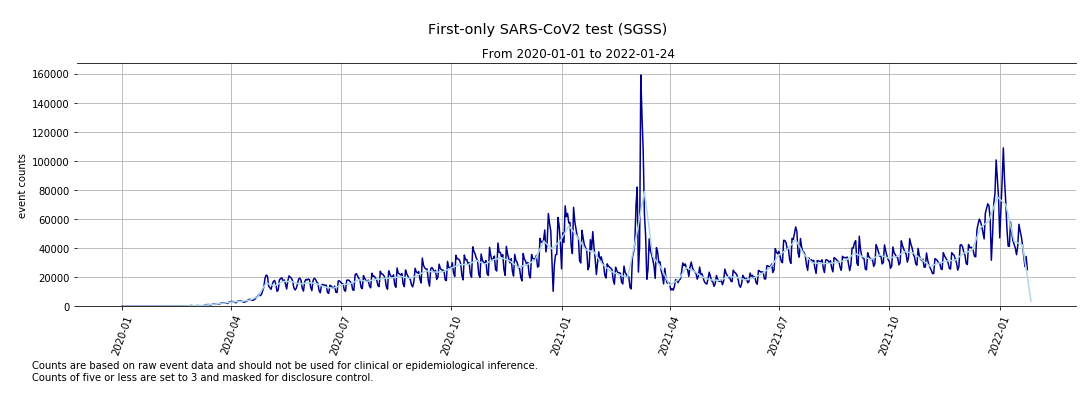

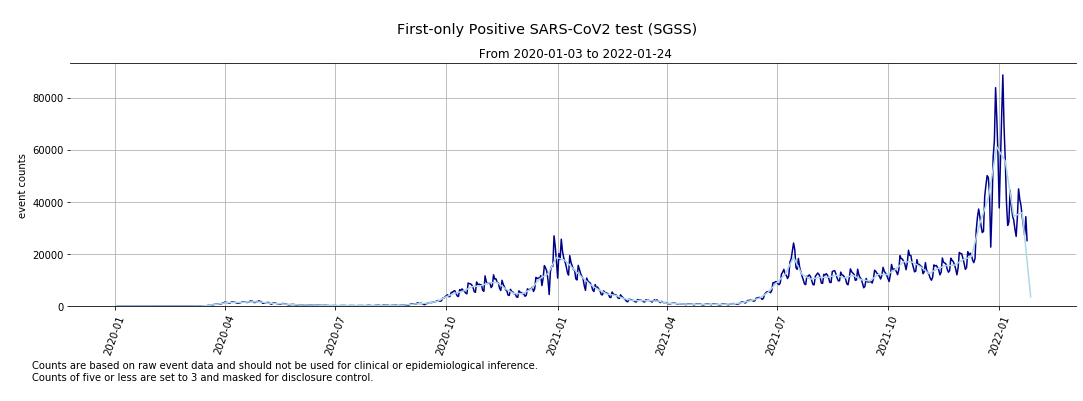

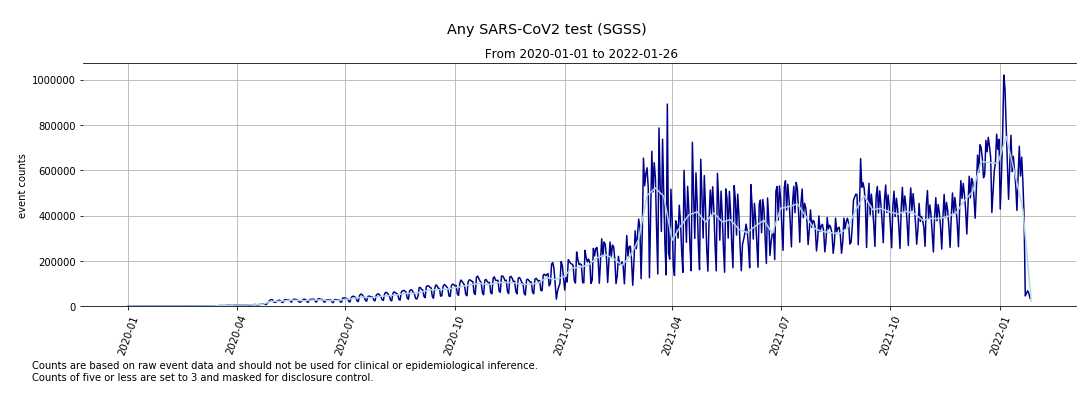

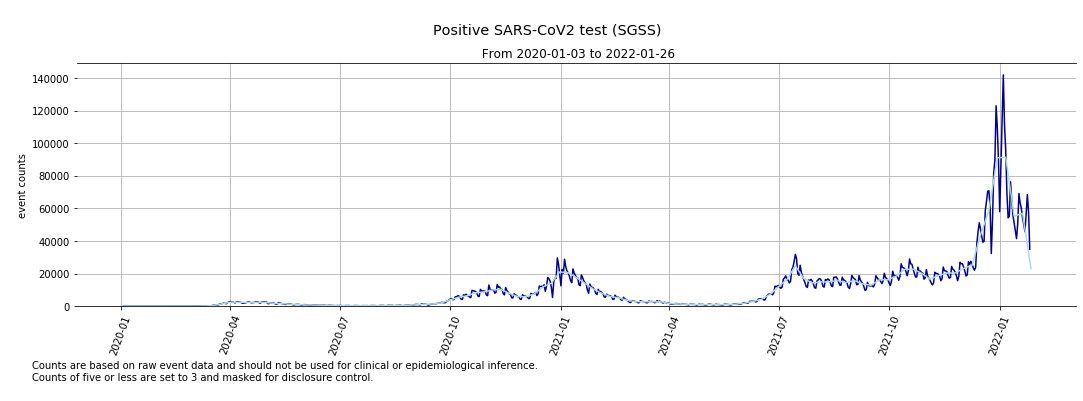

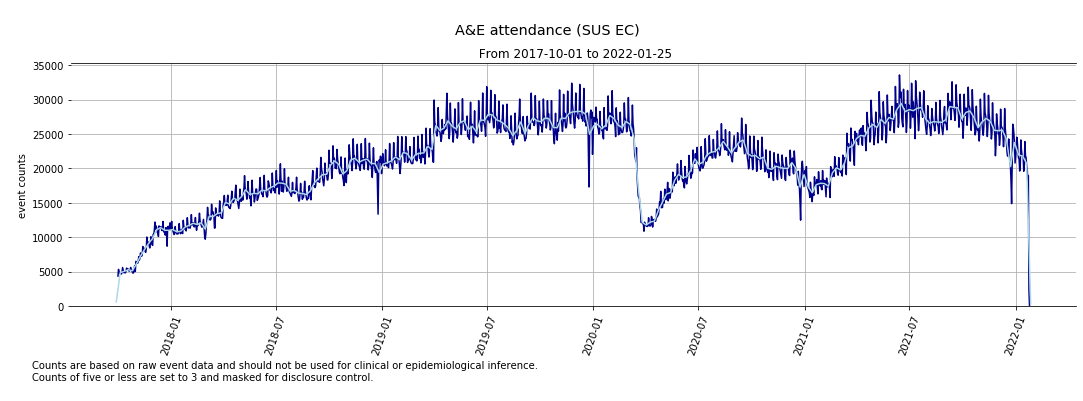

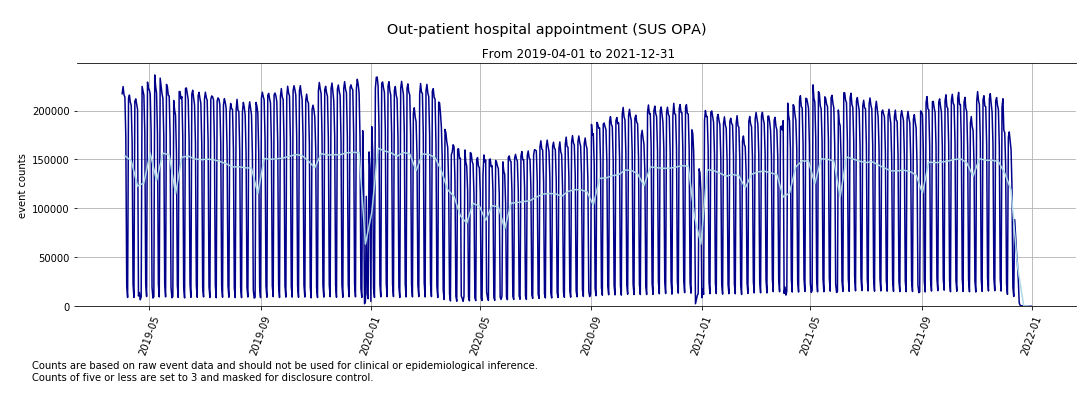

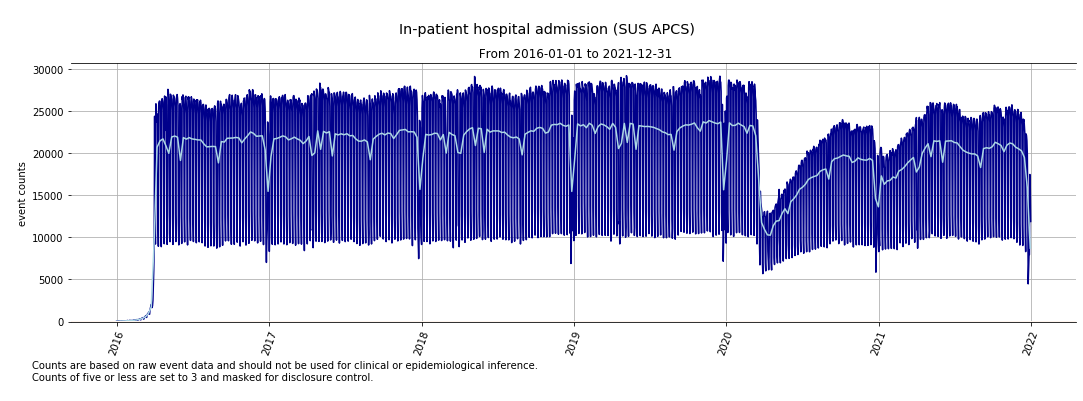

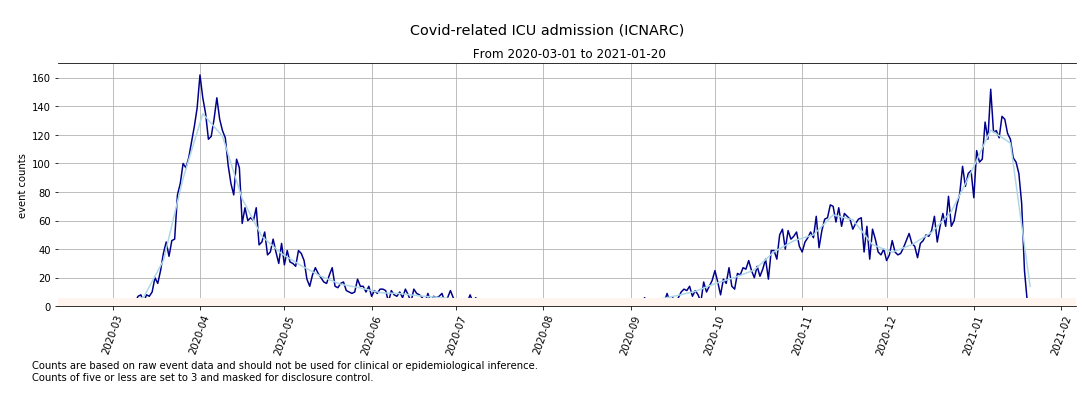

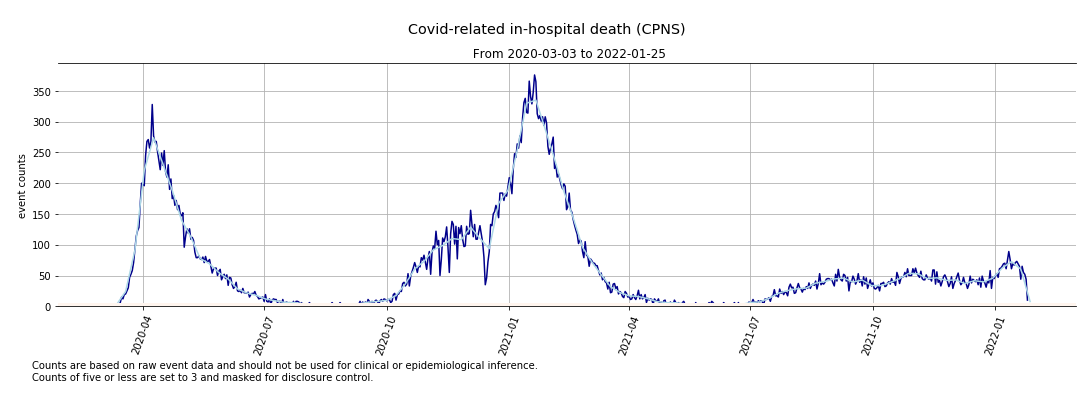

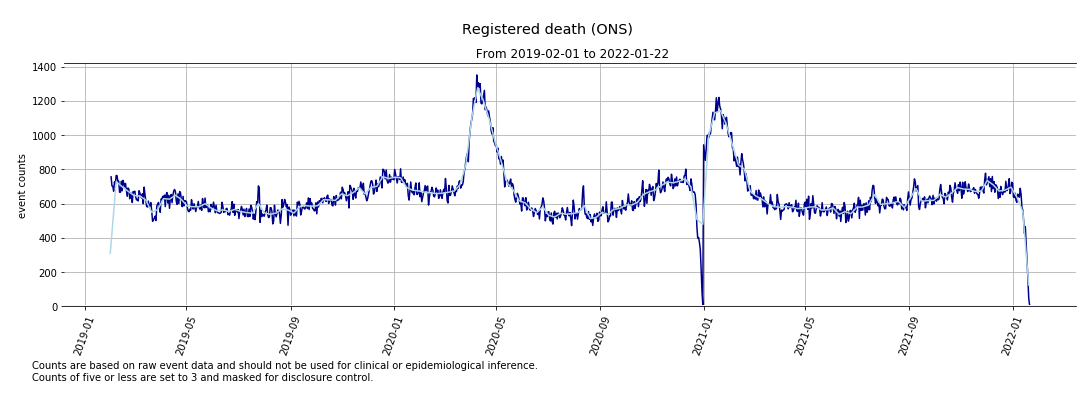

In [7]:
#plotcounts_history(CodedEvent_df['coded_event_date'], title="Any coded event in Primary Care, from SystmOne")
plotcounts_history(SGSS_df, title="First-only SARS-CoV2 test (SGSS)")
plotcounts_history(SGSSpos_df, title="First-only Positive SARS-CoV2 test (SGSS)")
plotcounts_history(SGSS_all_df, title="Any SARS-CoV2 test (SGSS)")
plotcounts_history(SGSSpos_all_df, title="Positive SARS-CoV2 test (SGSS)")
plotcounts_history(EC_df, title="A&E attendance (SUS EC)")
plotcounts_history(OPA_df, title="Out-patient hospital appointment (SUS OPA)")
plotcounts_history(APCS_df, title="In-patient hospital admission (SUS APCS)")
plotcounts_history(ICNARC_df, title="Covid-related ICU admission (ICNARC)")
plotcounts_history(CPNS_df, title="Covid-related in-hospital death (CPNS)")
plotcounts_history(ONS_df, title="Registered death (ONS)")